In [1]:
# test calculations

#TODO
# rename variables and add pressure levels 
# calculate indices
# compare to other indices


In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

P=200
p=P
p0 = P-50
p1 = P+50
P0 = 1000
step_size=  0.1545 # fraction of degree
metres_per_degree = 111111

# these functions are used to calculate turbulence in climate models
# calculate differential components
def dy(ds, y= step_size,):
    """Step size in degrees. This function converts to metres"""
    return metres_per_degree * y
    # * ds[lon]**0

def dx(ds, lat="lat", x= step_size,):
    """Step size in degrees. This function converts to metres"""
    return metres_per_degree * np.cos( np.deg2rad(ds[lat])) * x

def dz(ds, z="z", p0=p0, p1=p1):
    """Change in height"""
    return ds[z].sel(pressure=p0) - ds[z].sel(pressure=p1)
    
def du_dx(ds, u="u", lon="lon",lat="lat", p=P, x=step_size):
    """Change in horizontal wind u with change in longitude."""
    return ds[u].sel(pressure=p).diff(lon)/dx(ds, lat=lat, x= 1,)

def dv_dx(ds, v="v", lon="lon",lat="lat", p=P, x= step_size):
    """Change in horizontal wind v with change in longitude (step_size for x).
    This function wraps similar du_dx function"""
    return du_dx(ds, u=v, lon=lon, lat=lat, p=p, x=x)

def du_dy(ds, u="u", lon="lon",lat="lat", p=P, y=step_size):
    """Change in horizontal wind u with change in latitude."""
    # return ds[u].sel(pressure=p).diff(lat)*y/dy(ds, y= y,)
    return (ds[u].sel(pressure=p)).diff(lat)/dy(ds, y= 1,)

def dv_dy(ds, v="v", lon="lon",lat="lat", p=P, y=step_size):
    """Change in horizontal wind v with change in latitude.
    This function wraps similar du_dy function"""
    return du_dy(ds, u=v, lon=lon, lat=lat, p=p, y=y)
    # return (ds[v].sel(pressure=p)* np.cos( np.deg2rad(ds[lat]))).diff(lat)*y/(dy(ds, y= y,)* np.cos( np.deg2rad(ds[lat])))

def du_dz(ds, u="u", z="z", p0=p0, p1=p1):
    """Change in horizontal wind u with change in  height."""
    return (ds[u].sel(pressure=p0) - ds[u].sel(pressure=p1))/dz(ds, z=z, p0=p0, p1=p1)

def dv_dz(ds, v="v", z="z", p0=p0, p1=p1):
    """Change in horizontal wind v with change in  height.
    This function wraps similar du_dz function"""
    return du_dz(ds, u=v, z=z, p0=p0, p1=p1)

# Calculate indices
def windspeed(ds, u="u", v="v",):
    """Horizontal windspeed"""
    return np.hypot(ds[u], ds[v])
    
def air_density(ds, t="t", p=P,):
    """Calculates air density from temperature (T) and pressure (P) according to the ideal gas law.
    R_specific is the specific gas constant for dry air
    Units: 
    * P in hPa (convert to Pa)
    * T in K
    * R_specific in J/kg/K
    """
    R_specific = 287.05
    T = ds[t]
    return p*100/(R_specific * T)
rho = air_density
    
def potential_temperature(ds, t = "t", p=P, P0=P0):
    """Calculates potential temperature from temperature (T) and pressure (P) according to the ideal gas law.
    R/c_p = 0.286 for air
    Units: 
    * P in hPa
    * T in K
    p is pressure level you are interested in
    P0 is the reference pressure usually 1000hPa
    """
    T = ds[t]
    return T*(P0/p)**(0.2857)
theta = potential_temperature
    
def vertical_temperature_gradient(ds, t="t", P0=P0, z="z", p0=p0, p1=p1):
    return (potential_temperature(ds, t=t, p=p0, P0=P0) - potential_temperature(ds, t=t, p=p1, P0=P0))/dz(ds, z=z, p0=p0, p1=p1)
dtheta_dz = vertical_temperature_gradient

def BruntVaisala_frequency(ds, t="t", p=P, P0=P0, z="z", p0=p0, p1=p1, g=9.81):
    """N^2 Brunt-Vӓisӓlӓ frequency"""
    return g/(potential_temperature(ds, t=t, p=p, P0=P0)) * dtheta_dz(ds, t=t, z=z, p0=p0, p1=p1)
N2 = BruntVaisala_frequency

def coriolis_freq(ds, lat="lat"):
    # omega constant for earth, change for other planets
    omega = 7.2921*10**-5
    return 2*omega*np.sin(np.deg2rad(ds[lat]))
f = coriolis_freq

def vertical_vorticity(ds, u="u", v="v",
                        p=P,
                        lon="lon", lat="lat",
                        x= step_size, y=step_size):
    return dv_dx(ds, v=v, lon=lon, lat=lat, p=p, x=x) - du_dy(ds, u=u, lon=lon, lat=lat, p=p, y=y)
zeta = vertical_vorticity

def potential_vorticity(ds, u="u", v="v", t="t", z="z",
                        p=P, P0=P0, p0=p0, p1=p1, 
                        lon="lon", lat="lat",
                        x= step_size, y=step_size):
    "PV Potential Vorticity"
    f = coriolis_freq(ds, lat=lat)
    return 1/air_density(ds, t=t, p=p) * (zeta(ds, u=u, v=v, p=p, lon=lon, lat=lat, x= x, y=y) + f)* dtheta_dz(ds, t=t, P0=P0, z=z, p0=p0, p1=p1)
PV = potential_vorticity

def vertical_wind_shear(ds, u="u", v="v", z="z", p0=p0, p1=p1):
    return np.hypot(du_dz(ds, u=u, z=z, p0=p0, p1=p1),
                    dv_dz(ds, v=v, z=z, p0=p0, p1=p1))
VWS = vertical_wind_shear

def DSH(ds, u="u", v="v", lon="lon", lat="lat", p=P, x= step_size, y= step_size):
    """Shearing deformation"""
    return dv_dx(ds, v=v, lon=lon, lat=lat, p=p, x=x) + du_dy(ds, u=u, lon=lon, lat=lat, p=p, y=y)

def DST(ds, u="u", v="v", lon="lon", lat="lat", p=P, x= step_size, y= step_size):
    """Stretching deformation"""
    return du_dx(ds, u=u, lon=lon, lat=lat, p=p, x=x) - dv_dy(ds, v=v, lon=lon, lat=lat, p=p, y=y)
    
def deformation(ds, u="u", v="v", lon="lon", lat="lat", p=P, x= step_size, y= step_size):
    """sqrt((dvdx+dudy)**2 + (dudx-dvdy)**2)"""
    return np.hypot(DSH(ds, u=u, v=v, lon=lon, lat=lat, p=p, x= x, y= y),
                    DST(ds, u=u, v=v, lon=lon, lat=lat, p=p, x= x, y= y))
DEF = deformation

def divergence(ds, u="u", v="v", lon="lon", lat="lat", p=P, x= step_size, y= step_size):
    """dudx + dvdy"""
    return du_dx(ds, u=u, lon=lon, lat=lat, p=p, x=x) + dv_dy(ds, v=v, lon=lon, lat=lat, p=p, y=y)
DIV = divergence

def divergence_tendency(ds, u="u", v="v", lon="lon", lat="lat", p=P, x= step_size, y= step_size):
    C=0.01
    return C*((DIV(ds, u=u, v=v, lon=lon, lat=lat, p=p, x= step_size, y= step_size).differentiate("time", datetime_unit="6h")**2)**0.5)
DVT = divergence_tendency

def richardson_number(ds, u="u", v="v", t="t", z="z", p=P, p0=p0, p1=p1, P0=P0):
    """The Ri less than some small number indicates Kelvin-Helmholtz instability when VWS is large and/or N2 is small."""
    return  N2(ds, t=t, z=z, p=p, p0=p0, p1=p1, P0=P0)/(VWS(ds, u=u, v=v, z=z, p0=p0, p1=p1)**2)
Ri = richardson_number

def turbulence_index_1(ds, u="u", v="v", z="z", p0=p0, p1=p1, lon="lon", lat="lat", p=P, x= step_size, y= step_size):
    """Ellrod1 index = VWS*DEF """
    return VWS(ds, u=u, v=v, z=z, p0=p0, p1=p1) * DEF(ds, u=u, v=v, lon=lon, lat=lat, p=p, x=x, y=y)
TI1 = turbulence_index_1
elllrod1 = turbulence_index_1

def turbulence_index_2(ds, u="u", v="v", z="z", p0=p0, p1=p1, lon="lon", lat="lat", p=P, x= step_size, y= step_size):
    """Ellrod2 index = VWS*(DEF-DIV)"""
    return VWS(ds, u=u, v=v, z=z, p0=p0, p1=p1) * (DEF(ds, u=u, v=v, lon=lon, lat=lat, p=p, x=x, y=y) - DIV(ds, u=u, v=v, lon=lon, lat=lat, p=p, x= x, y= y))
TI2 = turbulence_index_2
elllrod2 = turbulence_index_2
    
def turbulence_index_3(ds, u="u", v="v", z="z", p0=p0, p1=p1, lon="lon", lat="lat", p=P, x= step_size, y= step_size):
    """Ellrod3 index - VWS * DEF + DVT"""
    return VWS(ds, u=u, v=v, z=z, p0=p0, p1=p1) * DEF(ds, u=u, v=v, lon=lon, lat=lat, p=p, x=x, y=y) + DVT(ds, u=u, v=v, lon=lon, lat=lat, p=p, x= x, y= y)
TI3 = turbulence_index_3
elllrod3 = turbulence_index_3


# calculate all turbulence indices   
def calc_turbulence_indices(
    ds, which=None,
    u="u", v="v", t="t", z="z",
    x=step_size, y=step_size,
    p=P, P0=P0, p0=None, p1=None, g=9.81,
    lon="lon", lat="lat"
):
    """
    Apply the turbulence index calculation to the dataset.

    Parameters
    ----------
    ds : xarray.Dataset
        Input dataset.
    which : str
        Index to compute. Case-sensitive.
        Options: ['air_density', 'theta', 'dtheta_dz', 'coriolis_freq', 'windspeed',
                  'VWS', 'N2', 'PV', 'DEF', 'DIV', 'DVT', 'Ri', 'TI1', 'TI2', 'TI3']
    """
    if p0 is None:
        p0=p-50
    if p1 is None:
        p1=p+50
    

    # Map index names to functions and their arguments
    index_map = {
        # "air_density": (air_density, dict(t=t, p=p)),
        # "theta": (potential_temperature, dict(t=t, p=p0, P0=P0)),
        # "dtheta_dz": (vertical_temperature_gradient, dict(t=t, P0=P0, z=z, p0=p0, p1=p1)),
        # "coriolis_freq": (coriolis_freq, dict(lat=lat)),
        "windspeed": (windspeed, dict(u=u, v=v)),
        "VWS": (VWS, dict(u=u, v=v, z=z, p0=p0, p1=p1)),
        "N2": (N2, dict(t=t, p=p, P0=P0, z=z, p0=p0, p1=p1)),
        "PV": (PV, dict(u=u, v=v, t=t, z=z, p=p, P0=P0, p0=p0, p1=p1, lon=lon, lat=lat, x=x, y=y)),
        "DEF": (DEF, dict(u=u, v=v, lon=lon, lat=lat, p=p, x=x, y=y)),
        "DIV": (DIV, dict(u=u, v=v, lon=lon, lat=lat, p=p, x=x, y=y)),
        "DVT": (DVT, dict(u=u, v=v, lon=lon, lat=lat, p=p, x=x, y=y)),
        "Ri": (Ri, dict(u=u, v=v, t=t, z=z, p=p, p0=p0, p1=p1, P0=P0)),
        "TI1": (TI1, dict(u=u, v=v, z=z, p0=p0, p1=p1, lon=lon, lat=lat, p=p, x=x, y=y)),
        "TI2": (TI2, dict(u=u, v=v, z=z, p0=p0, p1=p1, lon=lon, lat=lat, p=p, x=x, y=y)),
        "TI3": (TI3, dict(u=u, v=v, z=z, p0=p0, p1=p1, lon=lon, lat=lat, p=p, x=x, y=y)),
    }

    # Apply requested indices
    
    if which in index_map:
        func, kwargs = index_map[which]
        ds[which] = func(ds, **kwargs)
    else:
        raise ValueError(f"Unknown index: {which}")

    return ds


In [3]:
ds_test = xr.open_dataset("/scratch/v46/gt3409/catturb_mwtterm_AUS-15_ACCESS-CM2_historical_r4i1p1f1_BOM_BARPA-R_v1-r1_6hr_19860630.nc")
ds_test

<xarray.Dataset> Size: 818MB
Dimensions:   (lat: 436, lon: 777, time: 4, lev: 5)
Coordinates:
  * lat       (lat) float32 2kB -53.58 -53.42 -53.27 ... 13.32 13.48 13.63
  * lon       (lon) float32 3kB 88.04 88.19 88.34 88.5 ... 207.6 207.8 207.9
  * time      (time) float32 16B 0.0 6.0 12.0 18.0
  * lev       (lev) float32 20B 300.0 250.0 200.0 150.0 100.0
Data variables: (12/34)
    grdh      (lat, lon) float32 1MB ...
    hgtm      (lat, lon) float32 1MB ...
    mask      (lat, lon) float32 1MB ...
    maskm     (lat, lon) float32 1MB ...
    SPEED     (time, lev, lat, lon) float32 27MB ...
    Brown1    (time, lev, lat, lon) float32 27MB ...
    ...        ...
    wsqbyRi   (time, lev, lat, lon) float32 27MB ...
    NCSU1     (time, lev, lat, lon) float32 27MB ...
    NCSU2     (time, lev, lat, lon) float32 27MB ...
    Dutton    (time, lev, lat, lon) float32 27MB ...
    EDRLUN    (time, lev, lat, lon) float32 27MB ...
    EDRLL     (time, lev, lat, lon) float32 27MB ...

In [4]:
ds = xr.open_dataset("/g/data/v46/gt3409/turbulence_AUSCAT/sample-data_AUS-15_ACCESS-CM2_historical_r4i1p1f1_BOM_BARPA-R_v1-r1_6hr_19860630.nc")
levels = [50, 70, 100, 150, 200, 250, 300, 400]
params = ['clivi', 'clwvi', 'hus', 'orog', 'ta', 'ua', 'va', 'wa', 'zg']

dict_to_merge = {}
dict_to_merge_fx = {}
for param in params:
    try:
        dict_to_merge[param] = xr.concat([ds[f"{param}{plvl}"] for plvl in levels],
                                        dim=xr.DataArray(levels, dims="pressure", name="pressure"),).rename(param)
    except:
        dict_to_merge_fx[param] = xr.concat([ds[f"{param}"]],
                                        dim=xr.DataArray(["fx"], dims="pressure", name="pressure"),).rename(param)
new_ds_fx = xr.merge([dict_to_merge_fx[k] for k in dict_to_merge_fx.keys()], join="outer")
new_ds = xr.merge([dict_to_merge[k] for k in dict_to_merge.keys()], join="outer").assign_coords({"pressure":levels})

new_ds["lat"] = new_ds["lat"].astype("float32")
new_ds["lon"] = new_ds["lon"].astype("float32")

new_ds

<xarray.Dataset> Size: 260MB
Dimensions:   (time: 4, lon: 777, lat: 436, pressure: 8)
Coordinates:
  * time      (time) datetime64[ns] 32B 1986-06-30 ... 1986-06-30T18:00:00
  * lon       (lon) float32 3kB 88.04 88.19 88.34 88.5 ... 207.6 207.8 207.9
  * lat       (lat) float32 2kB -53.58 -53.42 -53.27 ... 13.32 13.48 13.63
  * pressure  (pressure) int64 64B 50 70 100 150 200 250 300 400
Data variables:
    hus       (pressure, time, lat, lon) float32 43MB 2.801e-06 ... 0.001093
    ta        (pressure, time, lat, lon) float32 43MB 213.9 213.9 ... 253.7
    ua        (pressure, time, lat, lon) float32 43MB 44.15 44.21 ... 9.496
    va        (pressure, time, lat, lon) float32 43MB -4.422 -4.398 ... -12.21
    wa        (pressure, time, lat, lon) float32 43MB -0.004883 ... -0.01758
    zg        (pressure, time, lat, lon) float32 43MB 1.995e+04 ... 7.526e+03
Attributes:
    long_name:      Specific Humidity
    standard_name:  specific_humidity
    units:          1
    cell_methods:   pressure: point time: point (interval: 6H) area: interpol...
    grid_mapping:   crs

# test indices

Test: min 0.0509, max 88.2283, median 16.5464
Mine: min 0.0509, max 88.2283, median 16.5468


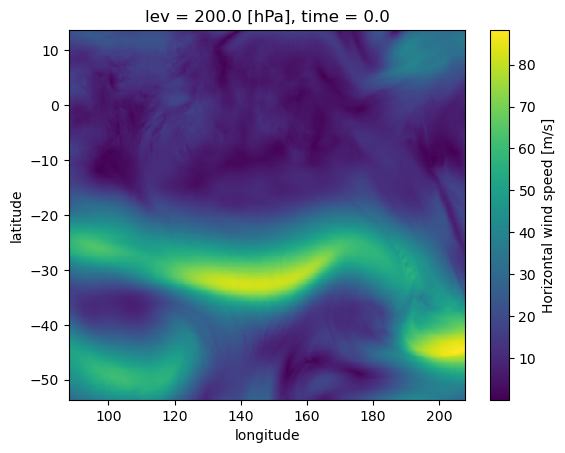

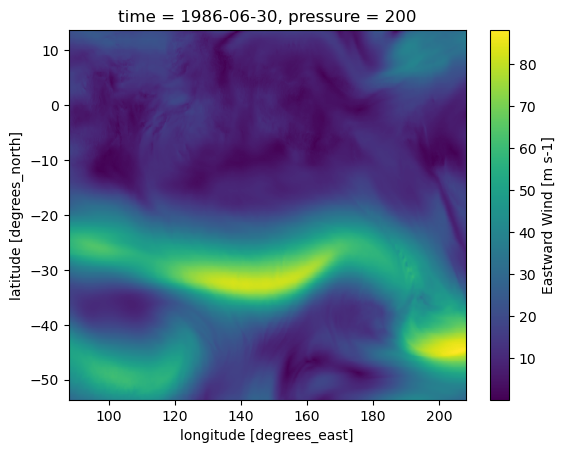

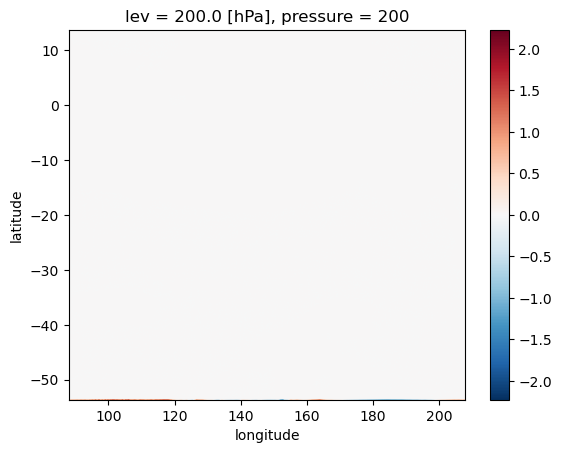

In [5]:
# windspeed
test = ds_test["SPEED"].sel({"time":0, "lev":200})
test_min, test_median, test_max = test.min().values, test.median().values, test.max().values
print(f"Test: min {test_min:.4f}, max {test_max:.4f}, median {test_median:.4f}")

mine = windspeed(new_ds, u="ua", v="va",).isel({"time":0}).sel({"pressure":200})
mine_min, mine_median, mine_max = mine.min(), mine.median(), mine.max()
print(f"Mine: min {mine_min:.4f}, max {mine_max:.4f}, median {mine_median:.4f}")

vmax = np.min((test_max, mine_max))
test.plot(vmax=vmax)
plt.figure()
mine.plot(vmax=vmax)
plt.figure()
(test -mine).plot()

Test: min 0.0000, max 0.0124, median 0.0030
Mine: min 0.0000, max 0.0119, median 0.0031


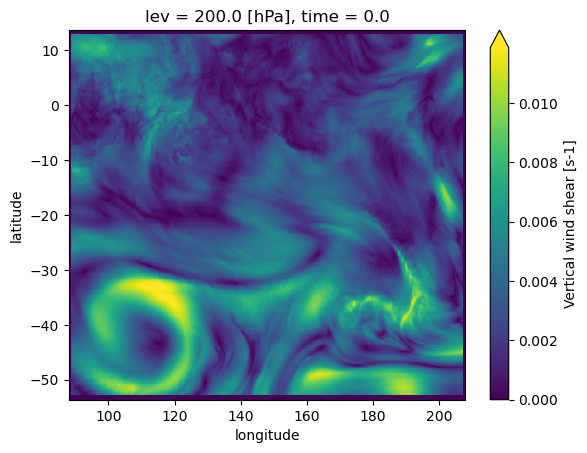

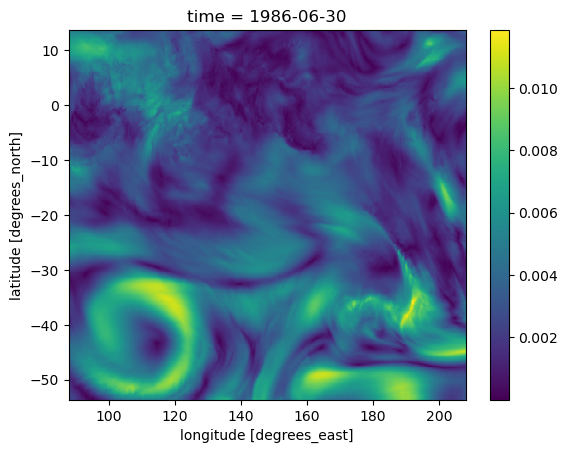

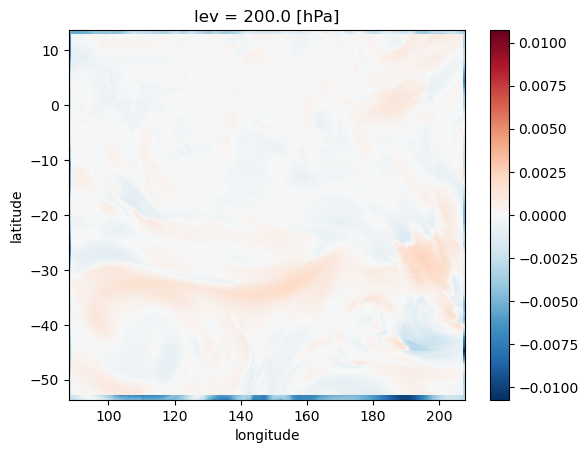

In [6]:
#vertical wind shear
test = ds_test["VWS"].sel({"time":0, "lev":200})
test_min, test_median, test_max = test.min().values, test.median().values, test.max().values
print(f"Test: min {test_min:.4f}, max {test_max:.4f}, median {test_median:.4f}")

mine = VWS(new_ds, u="ua", v="va", z="zg", p0=150, p1=250).isel({"time":0})
mine_min, mine_median, mine_max = mine.min(), mine.median(), mine.max()
print(f"Mine: min {mine_min:.4f}, max {mine_max:.4f}, median {mine_median:.4f}")

vmax = np.min((test_max, mine_max))
test.plot(vmax=vmax)
plt.figure()
mine.plot(vmax=vmax)
plt.figure()
(test -mine).plot()

In [7]:
DIV?

Signature: DIV(ds, u='u', v='v', lon='lon', lat='lat', p=200, x=0.1545, y=0.1545)
Docstring: dudx + dvdy
File:      /jobfs/159859792.gadi-pbs/ipykernel_45430/1013296047.py
Type:      function

Test: min 0.000000, max 0.000047, median 0.000000
Mine: min 0.000000, max 0.000059, median 0.000001


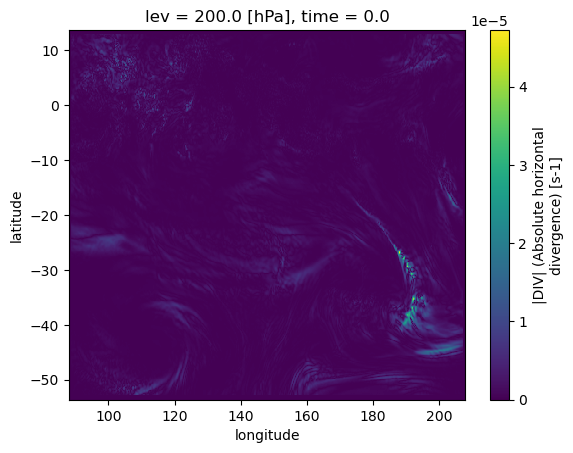

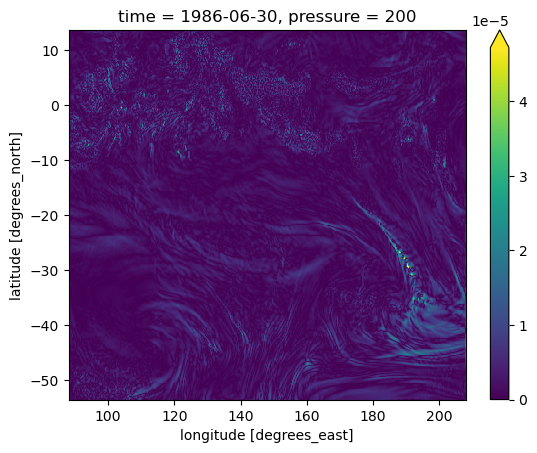

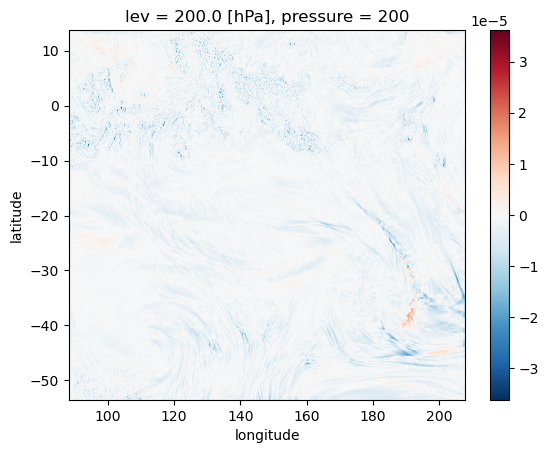

In [8]:
# divergence
test = ds_test["ABSDIV"].sel({"time":0, "lev":200})
test_min, test_median, test_max = test.min().values, test.median().values, test.max().values
print(f"Test: min {test_min:.6f}, max {test_max:.6f}, median {test_median:.6f}")

mine = np.abs(DIV(new_ds.isel({"time":0}), u="ua", v="va",))
mine_min, mine_median, mine_max = mine.min(), mine.median(), mine.max()
print(f"Mine: min {mine_min:.6f}, max {mine_max:.6f}, median {mine_median:.6f}")

vmax = np.min((test_max, mine_max))
test.plot(vmax=vmax)
plt.figure()
mine.plot(vmax=vmax)
plt.figure()
(test -mine).plot()

In [9]:
DEF?

Signature: DEF(ds, u='u', v='v', lon='lon', lat='lat', p=200, x=0.1545, y=0.1545)
Docstring: sqrt((dvdx+dudy)**2 + (dudx-dvdy)**2)
File:      /jobfs/159859792.gadi-pbs/ipykernel_45430/1013296047.py
Type:      function

Test: min 0.0000000000, max 0.0001090305, median 0.0000059913
Mine: min 0.0000000014, max 0.0000522155, median 0.0000052374


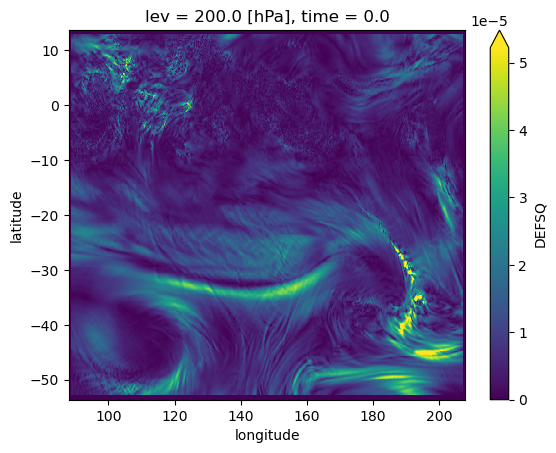

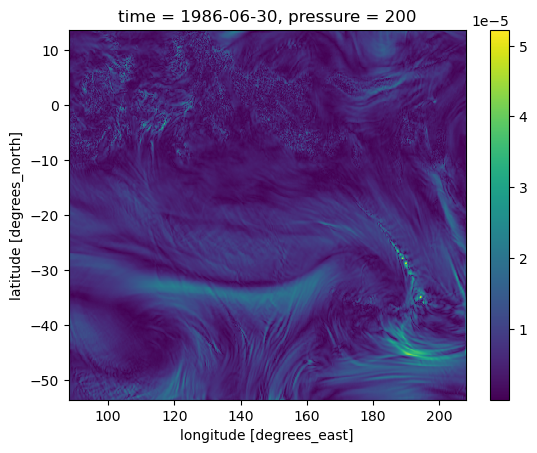

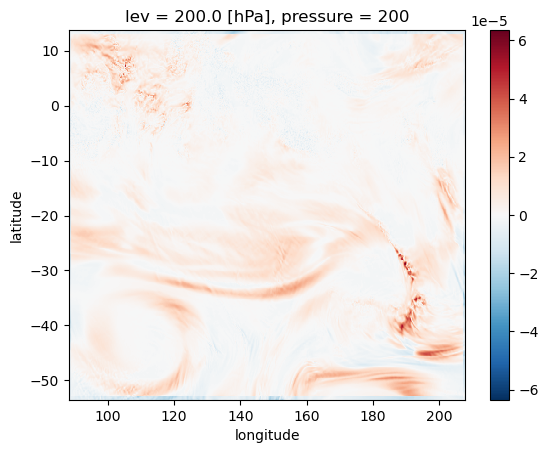

In [10]:
# deformation
test = ds_test["DEFSQ"].sel({"time":0, "lev":200})**.5
test_min, test_median, test_max = test.min().values, test.median().values, test.max().values
print(f"Test: min {test_min:.10f}, max {test_max:.10f}, median {test_median:.10f}")

mine = (DEF(new_ds, u="ua", v="va", p=200).isel({"time":0}))
mine_min, mine_median, mine_max = mine.min(), mine.median(), mine.max()
print(f"Mine: min {mine_min:.10f}, max {mine_max:.10f}, median {mine_median:.10f}")

vmax = np.min((test_max, mine_max))
test.plot(vmax=vmax)
plt.figure()
mine.plot(vmax=vmax)
plt.figure()
(test -mine).plot()

Test: min 0.000000000, max 0.000000844, median 0.000000017
Mine: min 0.000000000, max 0.000000452, median 0.000000014


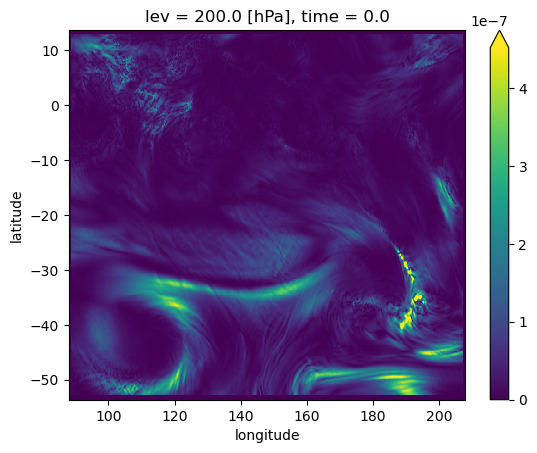

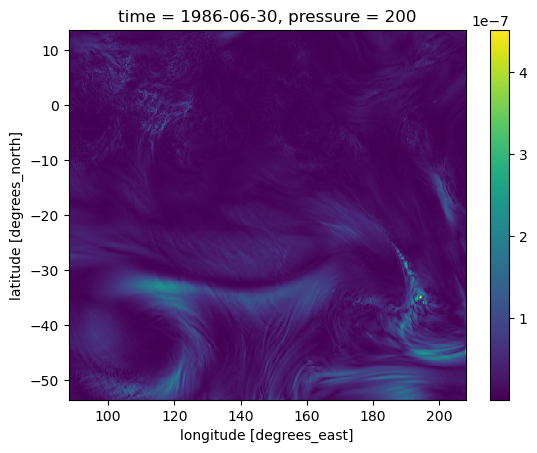

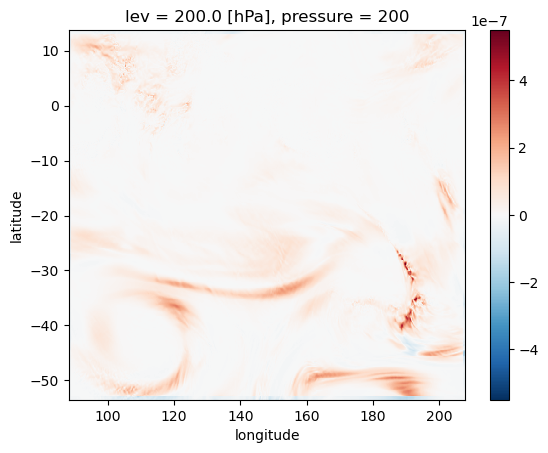

In [11]:
# Ellrod1
test = ds_test["VWS"].sel({"time":0, "lev":200}) * ds_test["DEFSQ"].sel({"time":0, "lev":200})**.5

test_min, test_median, test_max = test.min().values, test.median().values, test.max().values
print(f"Test: min {test_min:.9f}, max {test_max:.9f}, median {test_median:.9f}")

mine = TI1(new_ds, u="ua", v="va", z="zg", p=P).isel({"time":0})
mine_min, mine_median, mine_max = mine.min(), mine.median(), mine.max()
print(f"Mine: min {mine_min:.9f}, max {mine_max:.9f}, median {mine_median:.9f}")

vmax = np.min((test_max, mine_max))
test.plot(vmax=vmax)
plt.figure()
mine.plot(vmax=vmax)
# plt.figure()
# (ds_test["Ellrod1"].sel({"time":0, "lev":200})).plot(vmax=vmax)
plt.figure()
(test -mine).plot()

Test: min 0.000000000, max 0.000000006, median 0.000000000
Mine: min 0.000000000, max 0.000000002, median 0.000000000


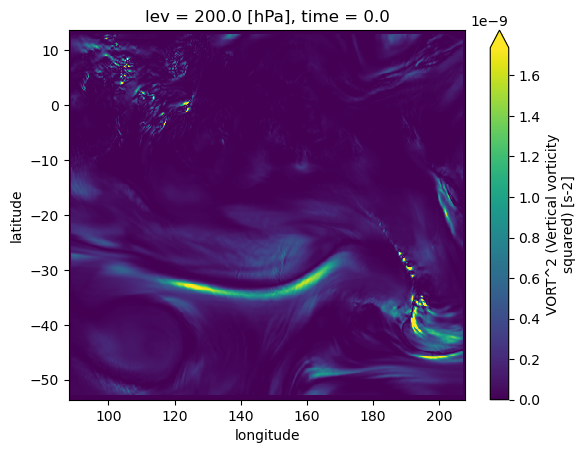

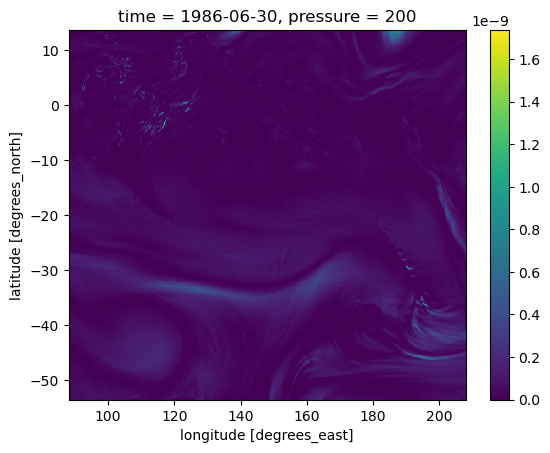

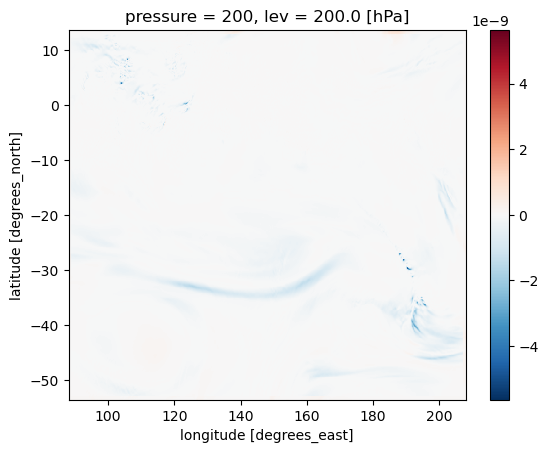

In [12]:
# vertical_vorticity (zeta) squared
test = ds_test["VORTSQ"].sel({"time":0, "lev":200})
test_min, test_median, test_max = test.min().values, test.median().values, test.max().values
print(f"Test: min {test_min:.9f}, max {test_max:.9f}, median {test_median:.9f}")

mine = (vertical_vorticity(new_ds, u="ua", v="va", p=P).isel({"time":0}))**2
mine_min, mine_median, mine_max = mine.min(), mine.median(), mine.max()
print(f"Mine: min {mine_min:.9f}, max {mine_max:.9f}, median {mine_median:.9f}")

# vmax = 2*10**-9
vmax = np.min((test_max, mine_max))
test.plot(vmax=vmax)
plt.figure()
mine.plot(vmax=vmax)
plt.figure()
(mine - test).plot()

Test: min 0.0000, max 0.3297, median 0.0324
Mine: min 0.0000, max 0.3108, median 0.0215


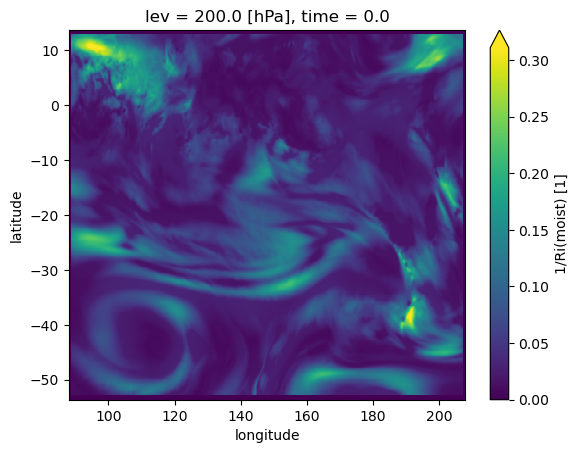

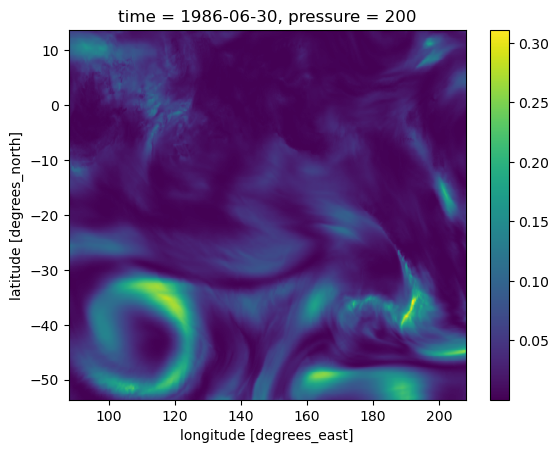

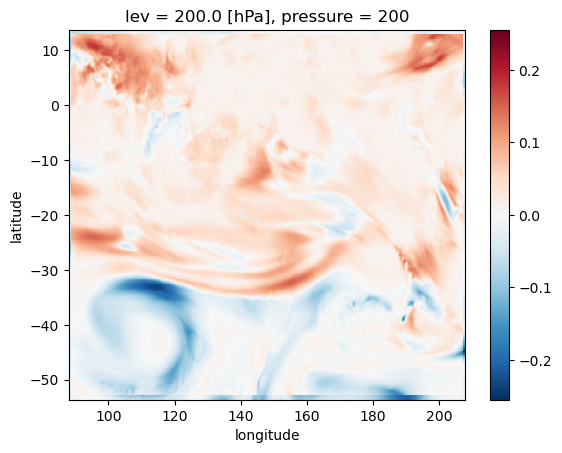

In [13]:
# Richardson number
test = ds_test["Rimn"].sel({"time":0, "lev":200})
test_min, test_median, test_max = test.min().values, test.median().values, test.max().values
print(f"Test: min {test_min:.4f}, max {test_max:.4f}, median {test_median:.4f}")

mine = (1/Ri(new_ds, u="ua", v="va", t="ta", z="zg", p = 200, p0=150, p1=250, P0=1000)).isel({"time":0}).sel({"pressure":200})
mine_min, mine_median, mine_max = mine.min(), mine.median(), mine.max()
print(f"Mine: min {mine_min:.4f}, max {mine_max:.4f}, median {mine_median:.4f}")

vmax = np.min((test_max, mine_max))
test.plot(vmax=vmax)
plt.figure()
mine.plot(vmax=vmax)
plt.figure()
(test -mine).plot()

Test: min 0.0000, max 0.3297, median 0.0324
Mine: min 0.0000, max 0.3108, median 0.0215


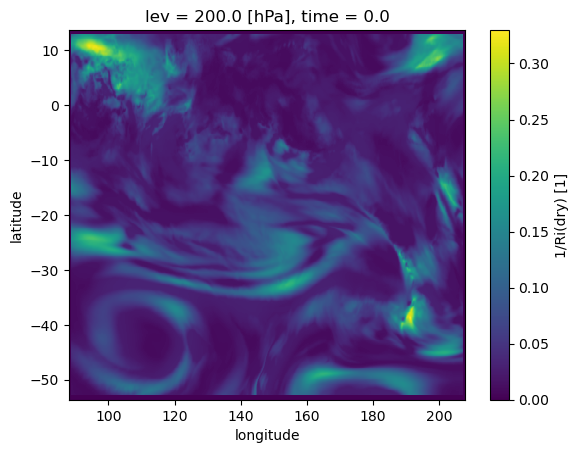

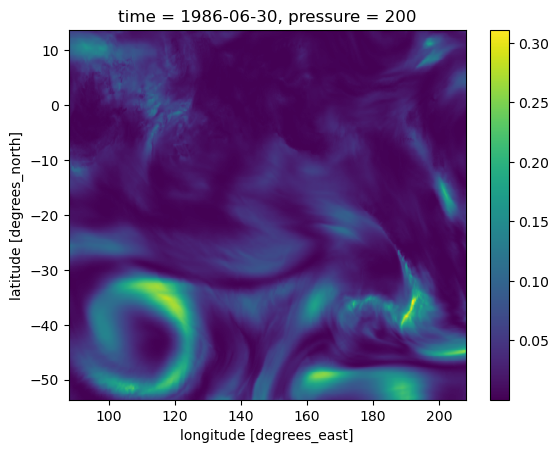

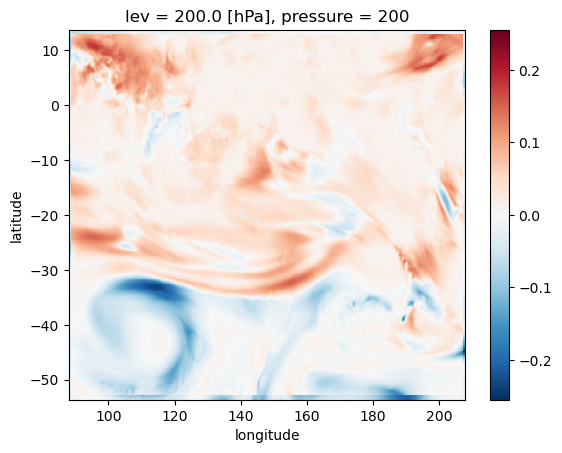

In [14]:
# Richardson number
test = ds_test["Ridn"].sel({"time":0, "lev":200})
test_min, test_median, test_max = test.min().values, test.median().values, test.max().values
print(f"Test: min {test_min:.4f}, max {test_max:.4f}, median {test_median:.4f}")

mine = (1/Ri(new_ds, u="ua", v="va", t="ta", z="zg", p = 200, p0=150, p1=250, P0=1000)).isel({"time":0}).sel({"pressure":200})
mine_min, mine_median, mine_max = mine.min(), mine.median(), mine.max()
print(f"Mine: min {mine_min:.4f}, max {mine_max:.4f}, median {mine_median:.4f}")

test.plot()
plt.figure()
mine.plot()
plt.figure()
(test -mine).plot()

# check to see if theirs is internally consistent

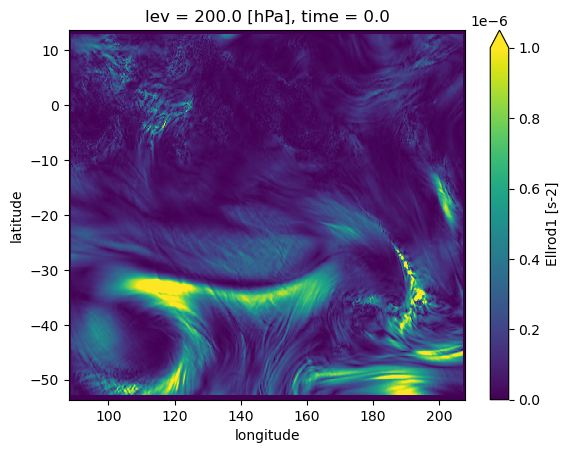

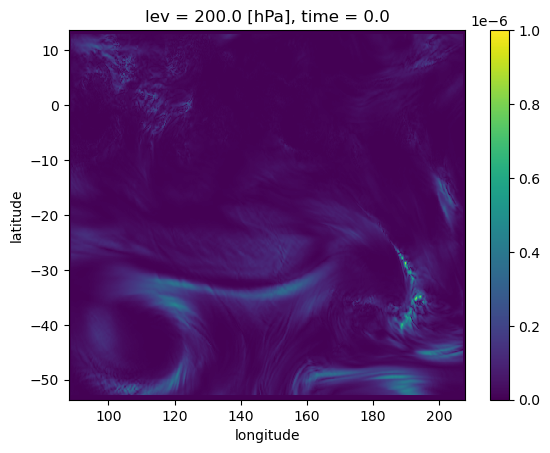

In [15]:
# theirs is not internally consistent
# Ellrod1 = VWS * DEF
sub_ds = ds_test.sel({"time":0, "lev":200})
vmax=10**-6
(sub_ds["Ellrod1"]).plot(vmax=vmax)
plt.figure()
(sub_ds["VWS"] * sub_ds["DEFSQ"]**.5 ).plot(vmax=vmax)


<Figure size 640x480 with 0 Axes>

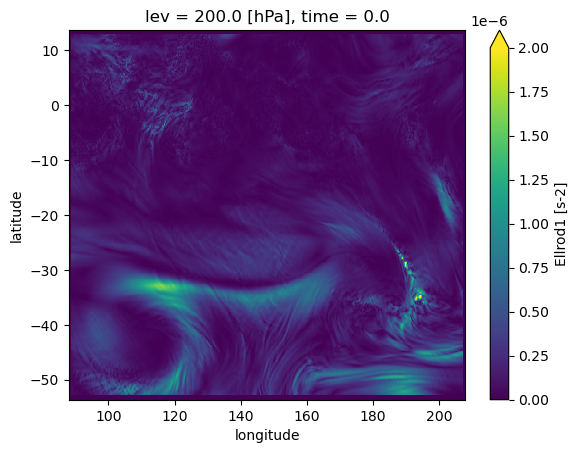

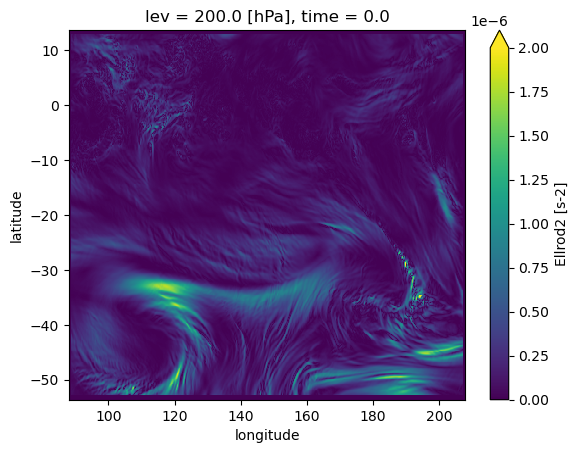

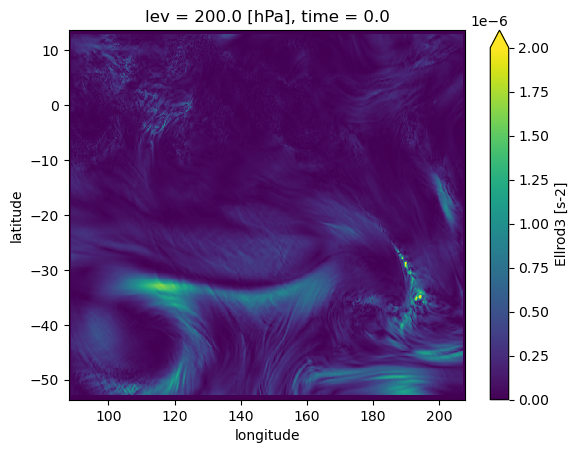

<Figure size 640x480 with 0 Axes>

In [16]:
# all ELLrod indices look the same? Or very similar
vmax=2*10**-6
(ds_test["Ellrod1"].sel({"time":0, "lev":200})).plot(vmax=vmax)
plt.figure()
(ds_test["Ellrod2"].sel({"time":0, "lev":200})).plot(vmax=vmax)
plt.figure()
(ds_test["Ellrod3"].sel({"time":0, "lev":200})).plot(vmax=vmax)
plt.figure()

# building blocks


<Figure size 640x480 with 0 Axes>

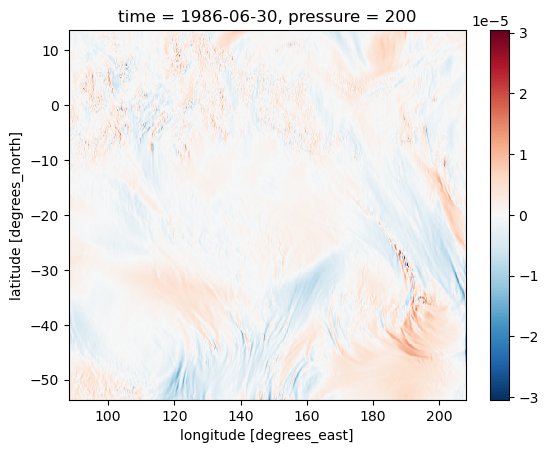

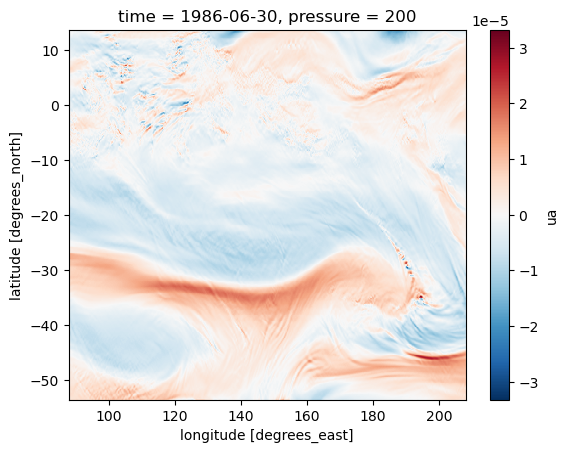

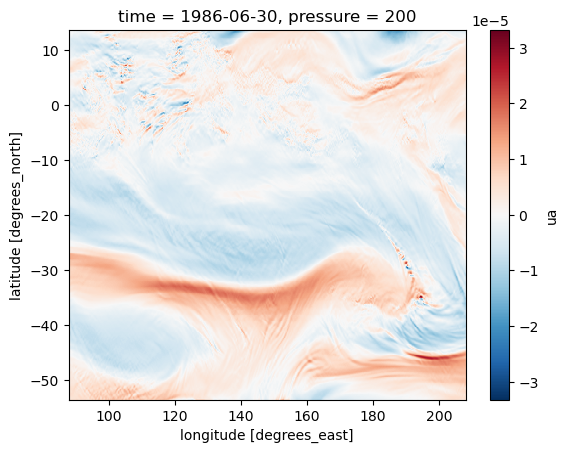

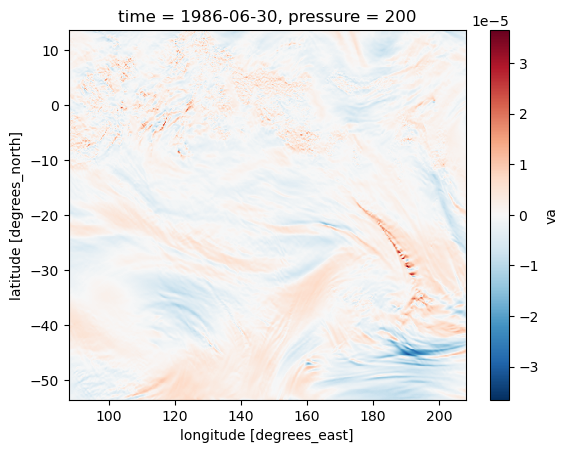

<Figure size 640x480 with 0 Axes>

In [17]:
dudx = du_dx(new_ds, u="ua", lon='lon', lat='lat', p = 200,).isel({"time":0})
dudy = du_dy(new_ds, u="ua", lon='lon', lat='lat', p = 200,).isel({"time":0})
dvdx = dv_dx(new_ds, v="va", lon='lon', lat='lat', p = 200,).isel({"time":0})
dvdy = dv_dy(new_ds, v="va", lon='lon', lat='lat', p = 200,).isel({"time":0})


dudx.plot()
plt.figure()
dudy.plot()
plt.figure()
dudy.plot()
plt.figure()
dvdy.plot()
plt.figure()
